In [1]:
import torch, shap, glob
import numpy as np, pandas as pd, torchvision.transforms as transforms
import random

from feedback import *
from tqdm.notebook import tqdm
from torch.nn import Module
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image

np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

In [2]:
npy_path = './np_image_totalunit/binaryclass_nactg_400px/'
# npy_path = './np_image_totalunit/multiclass_totalunit/'

save_weight_path ='./models/weights_res18_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.18[NATCG]_400px/'
if not os.path.exists(save_weight_path):
    os.mkdir(save_weight_path)

# save_weight_path = './models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/'

weights_name = "weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.18.pt"
# weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt"

path2weights = os.path.join(save_weight_path,weights_name)

In [3]:
npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
label_ = np.load(os.path.join(npy_path,'label.npy'))

In [4]:
label_[0:30]

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1])

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)

print(len(X_train), len(y_train)) 

print(len(X_test), len(y_test))

851 851
284 284


In [6]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class TransferDataset(Dataset):
    def __init__(self, s_path, labels, transform):
        self.transform = transform
        self.s_path = s_path
        self.labels = labels
        
    def __len__(self):
        return len(self.s_path)

    def __getitem__(self, idx):
        singel_image_ = np.load(self.s_path[idx]).astype(np.float32)
        seed = np.random.randint(1e9)       
        random.seed(seed)
        np.random.seed(seed)
        singel_image_ = self.transform(singel_image_)
        label = int(self.labels[idx])
        # print(label)

        return singel_image_, label

In [7]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean, std),
            ])     

train_ds = TransferDataset(s_path= X_train, labels= y_train, transform= transformer)
test_ds = TransferDataset(s_path= X_test, labels= y_test, transform= transformer)
print(len(train_ds), len(test_ds))

851 284


In [8]:
from torchvision.models import alexnet, resnet18
from torch.nn import Module
from torch import nn
model = resnet18(pretrained=False, num_classes=max(label_)+1)
# model = alexnet(pretrained=False, num_classes=max(label_)+1)
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# model

In [9]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# loss_func = nn.CrossEntropyLoss(reduction="sum", weight=class_weights)
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)
# path2weights = "./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.22.pt"
# torch.save(model.state_dict(), path2weights)
params_train={
    "num_epochs": 150,
    "optimizer": opt,
    "loss_func": loss_func,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2weights,
    }

In [10]:
import copy
import datetime
from tqdm import tqdm_notebook
from sklearn import metrics
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

class logs_realtime_reply:
    def __init__(self):
        self.avg_loss=np.inf
        self.running_metic = {"Loss":0, "Accuracy":0, "AUC":0}
        self.end_epoch_metric = None
    def metric_stack(self, inputs, targets, loss):

        classes = torch.argmax(inputs, dim=1)
        self.running_metic['Loss'] +=loss
        classes = torch.argmax(inputs, dim=1)
        acc = torch.mean((classes == targets).float())
        get_first_dim_pred = torch.sigmoid(inputs).detach().cpu().numpy()[:,1]
        fpr, tpr, _ = metrics.roc_curve(targets.cpu().numpy(), get_first_dim_pred, pos_label=1)
        self.running_metic['Accuracy'] += np.round(acc.cpu().numpy(), 5)*100
        self.running_metic['AUC'] += np.round(metrics.auc(fpr, tpr), 5)*100
    def mini_batch_reply(self, current_step, epoch, iter_len):
        # avg_reply_metric = {"Loss":None, "TP":None, "FP":None, "FN": None, "Spec": None, "Sens": None}
        avg_reply_metric = {"Loss":None, "Accuracy": None, "AUC": None}
        for j in avg_reply_metric:
            avg_reply_metric[j] = round(self.running_metic[j]/int(current_step),5)
        
        if current_step ==iter_len:
            self.end_epoch_metric = avg_reply_metric
        return avg_reply_metric
    def epoch_reply(self):
        return self.end_epoch_metric
        
def train(train_loader, model, criterion, optimizer, epoch):
    get_logs_reply = logs_realtime_reply()
    model.train()
    stream = tqdm(train_loader)
   
    for i, (image, label) in enumerate(stream, start=1):
        image=image.to(device)
        label=label.to(device)
        output=model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(optimizer, 0.5)
        optimizer.step()
        
        get_logs_reply.metric_stack(output, label, loss = round(loss.item(), 5))
        avg_reply_metric = get_logs_reply.mini_batch_reply(i, epoch, len(stream))
        avg_reply_metric['lr'] = optimizer.param_groups[0]['lr']
        stream.set_description(f"Epoch: {epoch}. Train. {str(avg_reply_metric)}")
    return avg_reply_metric['Loss'], avg_reply_metric['Accuracy'], avg_reply_metric['AUC']
# model validate
def validate(valid_loader, model, criterion, epoch):
    global best_vloss, best_vacc
    get_logs_reply2 = logs_realtime_reply()
    model.eval()
    stream_v = tqdm(valid_loader)
    with torch.no_grad():
        for i, (image, label) in enumerate(stream_v, start=1):
            image=image.to(device)
            label=label.to(device)
            output=model(image)
            loss = criterion(output, label)
            get_logs_reply2.metric_stack(output, label, loss = round(loss.item(), 5))
            avg_reply_metric = get_logs_reply2.mini_batch_reply(i, epoch, len(stream_v))
            stream_v.set_description(f"Epoch: {epoch}. Valid. {str(avg_reply_metric)}")
        avg_reply_metric = get_logs_reply2.epoch_reply()

    for x in avg_reply_metric:
        if x=='Loss' and avg_reply_metric[x]<best_vloss:
            best_vloss = avg_reply_metric[x]
            current_loss = avg_reply_metric['Loss']
            best_ck_name = path2weights
            torch.save({
                    'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict(), 
                    'loss':  current_loss,}, best_ck_name)
            print('save...', best_ck_name)
    return avg_reply_metric['Loss'], avg_reply_metric['Accuracy'], avg_reply_metric['AUC']



def  train_valid_process_main(model):
    global best_vloss, best_vacc
    best_vloss = np.inf
    best_vacc = 0.00
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }

    auc_history={
        "train": [],
        "val": [],
    }
    # Subject Dataloader Building
    batch_size = 32
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                            shuffle=True)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                            shuffle=False)  

    for epoch in range(1, params_train["num_epochs"] + 1):
        train_loss, train_metric, train_auc = train(train_dl, model, loss_func, opt, epoch)
        val_loss, val_metric, val_auc = validate(test_dl, model, loss_func, epoch)
        print("Epoch: ",epoch, f" Train/Valid Loss: {train_loss}|{val_loss}  ", f" Train/Valid Accuracy: {train_metric}|{val_metric}")
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        auc_history["train"].append(train_auc)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        auc_history["val"].append(val_auc)
        lr_scheduler.step(val_loss)
    return loss_history, metric_history, auc_history

In [11]:
loss_history, metric_history,auc_history  = train_valid_process_main(model)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

save... ./models/weights_res18_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.18[NATCG]_400px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.18.pt
Epoch:  1  Train/Valid Loss: 23.02316|42.90816    Train/Valid Accuracy: 54.68444|41.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

save... ./models/weights_res18_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.18[NATCG]_400px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.18.pt
Epoch:  2  Train/Valid Loss: 22.05166|38.41622    Train/Valid Accuracy: 56.81652|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

save... ./models/weights_res18_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.18[NATCG]_400px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.18.pt
Epoch:  3  Train/Valid Loss: 21.28261|38.08363    Train/Valid Accuracy: 60.7517|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  4  Train/Valid Loss: 21.61211|38.6615    Train/Valid Accuracy: 58.20541|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

save... ./models/weights_res18_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.18[NATCG]_400px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.18.pt
Epoch:  5  Train/Valid Loss: 21.36849|38.04374    Train/Valid Accuracy: 60.35574|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  6  Train/Valid Loss: 21.28104|38.38639    Train/Valid Accuracy: 59.78922|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  7  Train/Valid Loss: 21.47355|38.27006    Train/Valid Accuracy: 60.0877|64.2408


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  8  Train/Valid Loss: 20.9644|40.59741    Train/Valid Accuracy: 60.63596|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  9  Train/Valid Loss: 21.46129|43.11271    Train/Valid Accuracy: 61.51315|41.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  10  Train/Valid Loss: 20.95682|41.6664    Train/Valid Accuracy: 59.47248|41.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  11  Train/Valid Loss: 20.63868|126.66636    Train/Valid Accuracy: 62.567|41.4286
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  12  Train/Valid Loss: 20.35065|51.80377    Train/Valid Accuracy: 65.30822|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  13  Train/Valid Loss: 19.45235|40.30884    Train/Valid Accuracy: 67.54385|44.3304


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  14  Train/Valid Loss: 18.25905|195.40866    Train/Valid Accuracy: 69.90133|41.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  15  Train/Valid Loss: 18.21131|71.40588    Train/Valid Accuracy: 71.97248|41.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  16  Train/Valid Loss: 17.5876|89.49395    Train/Valid Accuracy: 73.48319|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  17  Train/Valid Loss: 15.08024|88.32276    Train/Valid Accuracy: 77.88133|44.1072
Epoch 00017: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  18  Train/Valid Loss: 13.14531|100.10374    Train/Valid Accuracy: 81.8957|42.7678


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  19  Train/Valid Loss: 12.27597|90.61402    Train/Valid Accuracy: 82.35259|43.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  20  Train/Valid Loss: 10.16089|49.92908    Train/Valid Accuracy: 86.06848|73.0356


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  21  Train/Valid Loss: 10.0212|314.94384    Train/Valid Accuracy: 86.06848|41.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  22  Train/Valid Loss: 9.89727|392.71402    Train/Valid Accuracy: 86.59844|41.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  23  Train/Valid Loss: 9.12558|289.40946    Train/Valid Accuracy: 86.72637|58.5714
Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  24  Train/Valid Loss: 8.18315|93.99548    Train/Valid Accuracy: 89.61378|61.6518


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  25  Train/Valid Loss: 6.78749|40.03751    Train/Valid Accuracy: 91.356|77.7232


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  26  Train/Valid Loss: 6.74574|116.33292    Train/Valid Accuracy: 91.12452|60.2232


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  27  Train/Valid Loss: 6.43169|81.2155    Train/Valid Accuracy: 92.62915|71.2946


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  28  Train/Valid Loss: 6.41105|67.0942    Train/Valid Accuracy: 90.65544|58.5716


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  29  Train/Valid Loss: 5.83268|109.15968    Train/Valid Accuracy: 92.62915|60.8482
Epoch 00029: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  30  Train/Valid Loss: 5.84026|95.24912    Train/Valid Accuracy: 92.70226|52.9466


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  31  Train/Valid Loss: 5.43764|46.70673    Train/Valid Accuracy: 92.74489|75.3574


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  32  Train/Valid Loss: 4.02823|40.96875    Train/Valid Accuracy: 95.86989|84.8662


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  33  Train/Valid Loss: 3.91918|59.16067    Train/Valid Accuracy: 94.59674|76.2948


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  34  Train/Valid Loss: 4.86666|47.70174    Train/Valid Accuracy: 93.24441|75.8036


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  35  Train/Valid Loss: 4.54016|42.60422    Train/Valid Accuracy: 93.28704|76.9198
Epoch 00035: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  36  Train/Valid Loss: 3.94482|61.24357    Train/Valid Accuracy: 95.55922|77.9466


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  37  Train/Valid Loss: 3.29305|48.81389    Train/Valid Accuracy: 95.55922|79.3302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  38  Train/Valid Loss: 3.73895|118.32637    Train/Valid Accuracy: 95.32774|49.1072


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  39  Train/Valid Loss: 3.30861|48.88111    Train/Valid Accuracy: 95.17544|82.9914


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  40  Train/Valid Loss: 3.56883|39.49983    Train/Valid Accuracy: 95.25463|84.9554


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  41  Train/Valid Loss: 2.87567|43.00062    Train/Valid Accuracy: 97.0273|83.6162
Epoch 00041: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  42  Train/Valid Loss: 3.02286|46.4123    Train/Valid Accuracy: 95.55922|82.2324


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  43  Train/Valid Loss: 3.2098|45.28007    Train/Valid Accuracy: 95.75415|85.0448


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  44  Train/Valid Loss: 2.87679|44.22175    Train/Valid Accuracy: 97.22222|84.0178


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  45  Train/Valid Loss: 2.94946|48.5407    Train/Valid Accuracy: 96.94811|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  46  Train/Valid Loss: 3.34692|66.102    Train/Valid Accuracy: 95.94907|80.0


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  47  Train/Valid Loss: 2.9355|89.34558    Train/Valid Accuracy: 97.25878|65.3124
Epoch 00047: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  48  Train/Valid Loss: 3.00664|58.63143    Train/Valid Accuracy: 96.18056|82.3664


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  49  Train/Valid Loss: 2.5707|46.70103    Train/Valid Accuracy: 96.875|85.0446


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  50  Train/Valid Loss: 2.25098|44.37466    Train/Valid Accuracy: 97.41107|86.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  51  Train/Valid Loss: 2.62618|46.32003    Train/Valid Accuracy: 96.17448|85.893


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  52  Train/Valid Loss: 2.37716|59.44649    Train/Valid Accuracy: 97.25878|75.8928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  53  Train/Valid Loss: 2.29448|46.49166    Train/Valid Accuracy: 97.56944|86.1162
Epoch 00053: reducing learning rate of group 0 to 3.9063e-06.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  54  Train/Valid Loss: 2.33648|45.87677    Train/Valid Accuracy: 96.83237|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  55  Train/Valid Loss: 3.04437|45.5987    Train/Valid Accuracy: 95.25463|85.5804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  56  Train/Valid Loss: 2.4301|45.75593    Train/Valid Accuracy: 96.99074|86.8304


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  57  Train/Valid Loss: 2.95315|48.39546    Train/Valid Accuracy: 96.52778|85.5804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  58  Train/Valid Loss: 2.50349|46.00986    Train/Valid Accuracy: 97.56944|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  59  Train/Valid Loss: 3.26609|45.8877    Train/Valid Accuracy: 95.67496|85.8928
Epoch 00059: reducing learning rate of group 0 to 1.9531e-06.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  60  Train/Valid Loss: 2.34928|45.00135    Train/Valid Accuracy: 97.41107|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  61  Train/Valid Loss: 2.45166|45.20944    Train/Valid Accuracy: 96.71663|85.8926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  62  Train/Valid Loss: 2.62618|45.32019    Train/Valid Accuracy: 96.91156|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  63  Train/Valid Loss: 1.73777|45.18379    Train/Valid Accuracy: 98.37963|86.2052


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  64  Train/Valid Loss: 2.26211|45.41155    Train/Valid Accuracy: 97.17959|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  65  Train/Valid Loss: 2.18792|45.33649    Train/Valid Accuracy: 97.56944|86.2052
Epoch 00065: reducing learning rate of group 0 to 9.7656e-07.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  66  Train/Valid Loss: 1.82951|45.77011    Train/Valid Accuracy: 98.26389|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  67  Train/Valid Loss: 1.85459|45.99337    Train/Valid Accuracy: 97.72174|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  68  Train/Valid Loss: 2.17467|44.46579    Train/Valid Accuracy: 97.17959|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  69  Train/Valid Loss: 2.87449|46.06793    Train/Valid Accuracy: 96.18056|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  70  Train/Valid Loss: 2.69544|46.46919    Train/Valid Accuracy: 97.0273|85.8036


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  71  Train/Valid Loss: 2.63734|44.50509    Train/Valid Accuracy: 96.06481|85.491
Epoch 00071: reducing learning rate of group 0 to 4.8828e-07.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  72  Train/Valid Loss: 2.24576|45.08461    Train/Valid Accuracy: 97.06385|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  73  Train/Valid Loss: 2.42513|45.41783    Train/Valid Accuracy: 97.25878|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  74  Train/Valid Loss: 2.42011|45.7559    Train/Valid Accuracy: 97.37452|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  75  Train/Valid Loss: 2.44449|45.70563    Train/Valid Accuracy: 96.25367|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  76  Train/Valid Loss: 1.92471|45.35797    Train/Valid Accuracy: 98.03241|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  77  Train/Valid Loss: 2.01539|45.2266    Train/Valid Accuracy: 98.41619|86.8302
Epoch 00077: reducing learning rate of group 0 to 2.4414e-07.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  78  Train/Valid Loss: 2.48346|45.29901    Train/Valid Accuracy: 97.0273|86.116


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  79  Train/Valid Loss: 2.52168|46.35022    Train/Valid Accuracy: 96.56433|86.5178


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  80  Train/Valid Loss: 2.50586|45.89277    Train/Valid Accuracy: 96.60089|86.2052


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  81  Train/Valid Loss: 2.1651|45.52285    Train/Valid Accuracy: 97.72174|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  82  Train/Valid Loss: 1.99641|44.82566    Train/Valid Accuracy: 97.49026|86.116


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  83  Train/Valid Loss: 2.12812|46.03664    Train/Valid Accuracy: 97.68519|85.491
Epoch 00083: reducing learning rate of group 0 to 1.2207e-07.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  84  Train/Valid Loss: 2.25359|45.48066    Train/Valid Accuracy: 97.14304|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  85  Train/Valid Loss: 1.82986|45.88536    Train/Valid Accuracy: 97.91667|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  86  Train/Valid Loss: 2.79044|46.25878    Train/Valid Accuracy: 96.71663|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  87  Train/Valid Loss: 2.96032|45.98768    Train/Valid Accuracy: 96.52778|86.5178


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  88  Train/Valid Loss: 2.54964|46.01485    Train/Valid Accuracy: 96.41204|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  89  Train/Valid Loss: 1.66314|45.61431    Train/Valid Accuracy: 98.72685|86.8302
Epoch 00089: reducing learning rate of group 0 to 6.1035e-08.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  90  Train/Valid Loss: 2.38304|46.05664    Train/Valid Accuracy: 97.22222|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  91  Train/Valid Loss: 2.43369|45.23156    Train/Valid Accuracy: 97.4537|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  92  Train/Valid Loss: 2.10196|45.55357    Train/Valid Accuracy: 97.37452|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  93  Train/Valid Loss: 2.28406|44.81815    Train/Valid Accuracy: 97.64256|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  94  Train/Valid Loss: 2.27291|45.37653    Train/Valid Accuracy: 97.56944|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  95  Train/Valid Loss: 2.19229|45.88673    Train/Valid Accuracy: 97.37452|85.491
Epoch 00095: reducing learning rate of group 0 to 3.0518e-08.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  96  Train/Valid Loss: 2.35172|45.3772    Train/Valid Accuracy: 97.33796|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  97  Train/Valid Loss: 3.1378|45.76564    Train/Valid Accuracy: 95.52267|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  98  Train/Valid Loss: 2.08875|45.87185    Train/Valid Accuracy: 97.52681|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  99  Train/Valid Loss: 2.37165|45.46415    Train/Valid Accuracy: 96.64352|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  100  Train/Valid Loss: 2.19551|44.81104    Train/Valid Accuracy: 97.606|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  101  Train/Valid Loss: 2.35992|45.75463    Train/Valid Accuracy: 97.95322|86.5176
Epoch 00101: reducing learning rate of group 0 to 1.5259e-08.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  102  Train/Valid Loss: 1.87855|44.99088    Train/Valid Accuracy: 98.49537|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  103  Train/Valid Loss: 1.83979|45.79673    Train/Valid Accuracy: 98.1847|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  104  Train/Valid Loss: 2.0919|45.77644    Train/Valid Accuracy: 97.72174|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  105  Train/Valid Loss: 2.18779|45.57068    Train/Valid Accuracy: 97.49026|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  106  Train/Valid Loss: 2.69419|45.71581    Train/Valid Accuracy: 95.7907|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  107  Train/Valid Loss: 2.72536|46.37947    Train/Valid Accuracy: 96.64352|85.1786


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  108  Train/Valid Loss: 2.35287|45.04842    Train/Valid Accuracy: 97.22222|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  109  Train/Valid Loss: 2.45621|45.32385    Train/Valid Accuracy: 96.99074|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  110  Train/Valid Loss: 1.98603|45.02053    Train/Valid Accuracy: 97.80093|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  111  Train/Valid Loss: 2.91906|45.42864    Train/Valid Accuracy: 96.44859|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  112  Train/Valid Loss: 2.58445|45.51171    Train/Valid Accuracy: 96.75926|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  113  Train/Valid Loss: 2.0865|44.91255    Train/Valid Accuracy: 97.80093|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  114  Train/Valid Loss: 2.45846|46.06673    Train/Valid Accuracy: 97.606|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  115  Train/Valid Loss: 3.23318|46.11064    Train/Valid Accuracy: 96.44859|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  116  Train/Valid Loss: 2.28713|46.55784    Train/Valid Accuracy: 97.4537|86.5178


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  117  Train/Valid Loss: 2.1446|46.37428    Train/Valid Accuracy: 97.41107|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  118  Train/Valid Loss: 2.10176|45.01502    Train/Valid Accuracy: 97.606|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  119  Train/Valid Loss: 2.36587|46.60667    Train/Valid Accuracy: 97.33796|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  120  Train/Valid Loss: 2.67508|44.63644    Train/Valid Accuracy: 96.17448|85.8034


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  121  Train/Valid Loss: 1.971|44.69232    Train/Valid Accuracy: 98.41619|85.8034


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  122  Train/Valid Loss: 2.43256|45.19264    Train/Valid Accuracy: 97.33796|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  123  Train/Valid Loss: 2.57709|46.36492    Train/Valid Accuracy: 96.71663|86.5178


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  124  Train/Valid Loss: 2.30127|45.91263    Train/Valid Accuracy: 96.98467|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  125  Train/Valid Loss: 2.18739|45.74447    Train/Valid Accuracy: 97.56944|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  126  Train/Valid Loss: 2.63322|46.03124    Train/Valid Accuracy: 97.14304|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  127  Train/Valid Loss: 3.01217|47.09769    Train/Valid Accuracy: 96.13181|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  128  Train/Valid Loss: 2.85464|46.23859    Train/Valid Accuracy: 95.74804|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  129  Train/Valid Loss: 2.3332|46.23552    Train/Valid Accuracy: 97.4537|86.5178


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  130  Train/Valid Loss: 2.63676|45.52248    Train/Valid Accuracy: 96.56433|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  131  Train/Valid Loss: 2.39959|45.86872    Train/Valid Accuracy: 97.33796|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  132  Train/Valid Loss: 3.23515|45.65616    Train/Valid Accuracy: 96.06481|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  133  Train/Valid Loss: 2.73458|45.84594    Train/Valid Accuracy: 95.83333|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  134  Train/Valid Loss: 2.39797|45.95312    Train/Valid Accuracy: 97.68519|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  135  Train/Valid Loss: 2.35558|45.80955    Train/Valid Accuracy: 97.4537|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  136  Train/Valid Loss: 2.06307|45.34913    Train/Valid Accuracy: 97.56944|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  137  Train/Valid Loss: 1.93275|44.75358    Train/Valid Accuracy: 97.49026|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  138  Train/Valid Loss: 1.76605|45.09867    Train/Valid Accuracy: 97.95322|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  139  Train/Valid Loss: 2.15188|46.25656    Train/Valid Accuracy: 97.33796|86.5178


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  140  Train/Valid Loss: 1.88546|44.59857    Train/Valid Accuracy: 98.03241|86.116


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  141  Train/Valid Loss: 2.1683|45.7109    Train/Valid Accuracy: 97.68519|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  142  Train/Valid Loss: 1.94008|45.8855    Train/Valid Accuracy: 97.91667|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  143  Train/Valid Loss: 1.81386|44.9064    Train/Valid Accuracy: 98.26389|85.8034


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  144  Train/Valid Loss: 2.31766|45.86279    Train/Valid Accuracy: 97.83748|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  145  Train/Valid Loss: 2.13614|45.90481    Train/Valid Accuracy: 97.606|85.1784


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  146  Train/Valid Loss: 2.91194|45.76404    Train/Valid Accuracy: 97.0273|85.491


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  147  Train/Valid Loss: 2.71703|45.96568    Train/Valid Accuracy: 97.17959|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  148  Train/Valid Loss: 1.76913|45.80873    Train/Valid Accuracy: 98.37963|86.8302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  149  Train/Valid Loss: 2.70018|46.1633    Train/Valid Accuracy: 97.22222|86.5176


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  150  Train/Valid Loss: 2.68611|45.47348    Train/Valid Accuracy: 96.5217|85.1784


In [12]:
loss_history.keys()

dict_keys(['train', 'val'])

Text(0.5, 1.0, 'loss history')

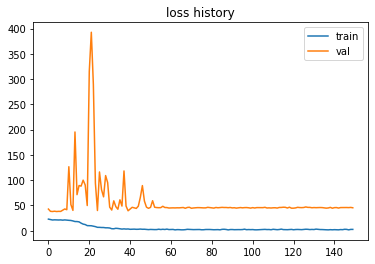

In [13]:
import matplotlib.pyplot as plt
plt.plot(loss_history['train'])
plt.plot(loss_history['val'])
plt.legend(['train','val'])
plt.title('loss history')

Text(0.5, 1.0, 'accuracy history')

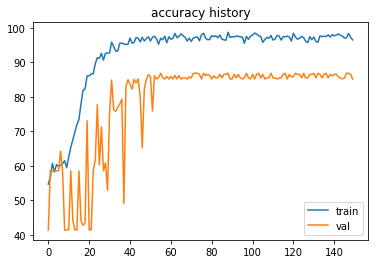

In [14]:
plt.plot(metric_history['train'])
plt.plot(metric_history['val'])
plt.legend(['train','val'])
plt.title('accuracy history')

Text(0.5, 1.0, 'auc history')

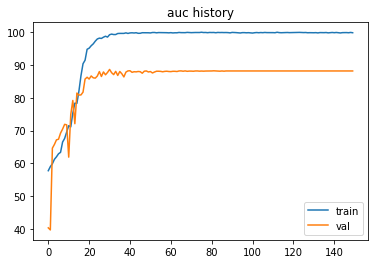

In [15]:
plt.plot(auc_history['train'])
plt.plot(auc_history['val'])
plt.legend(['train','val'])
plt.title('auc history')